In [1]:
using SpiDy
using NPZ
using DataFrames
using CSV
using ProgressMeter
using Random
using Statistics
using LinearAlgebra
using Plots

########################
########################

Δt = .2
N = 600
tspan = (0., N*Δt)
saveat = (0:1:N)*Δt

α = 10. # 0.16
ω0 = 7. # 1.4
Γ = 5. # 0.5


α = 0.16
ω0 = 1.4
Γ = 0.5


J = LorentzianSD(α, ω0, Γ) # coloring the noise
matrix = AnisoCoupling([-sin(π/4) 0. 0. # coupling to the environment
                        0. 0. 0.
                        cos(π/4) 0. 0.]);

matrix = IsoCoupling(1)

T = .01
noise = ClassicalNoise(T);

nspin = 1 # number of spins

s0 = [0, 1, 1] ./ sqrt(2)
J0 = 1.
JH = Nchain(nspin, J0)

nruns = 10000

10000

In [2]:
println("Starting...")
progress = Progress(nruns);

sols = zeros(nruns, length(saveat), 3*nspin)

Threads.@threads for i in 1:nruns
    bfields = [bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise)];
    sol = diffeqsolver(s0, tspan, J, bfields, matrix; JH=JH, saveat=saveat);
    sols[i, :, :] = transpose(sol[:, :])
    next!(progress)
end

solavg = mean(sols, dims=1)[1, :, :];
solstd = std(sols, dims=1)[1, :, :];

Starting...


Progress: 100%|█████████████████████████████████████████| Time: 0:01:392:11


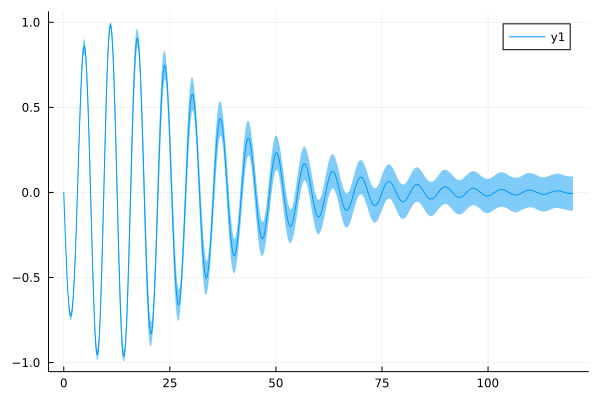

In [3]:
plot(saveat, solavg[:, 1], ribbon=solstd[:, 1])

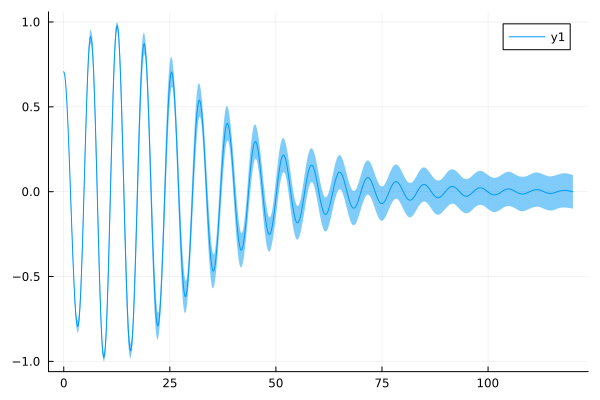

In [4]:
plot(saveat, solavg[:, 2], ribbon=solstd[:, 2])

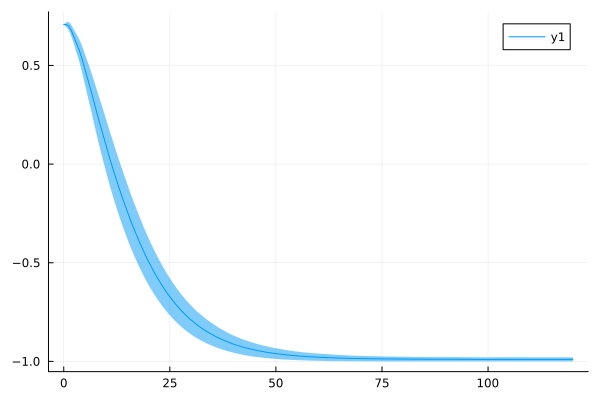

In [5]:
plot(saveat, solavg[:, 3], ribbon=solstd[:, 3])

In [6]:
projected = zeros(nruns, length(saveat), 2)

normalized_avg = [normalize(vec(row)) for row in eachrow(solavg)]

Threads.@threads for i in 1:length(saveat)
    n = normalized_avg[i, :][1]

    u = normalize(cross(n, [0,0,1]))
    v = cross(u, n)

    for j in 1:nruns
        b = sols[j, i, :]
        proj = dot(b, n) * n
        b_ort = b - proj

        projected[j, i, 1] = dot(u,b)
        projected[j, i, 2] = dot(v,b)
    end
end

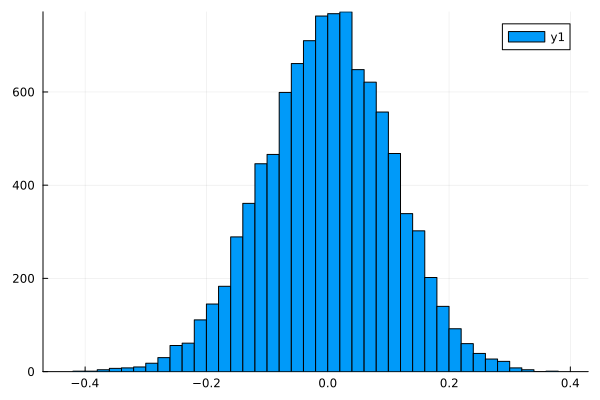

In [7]:
histogram(projected[:, 280, 1])

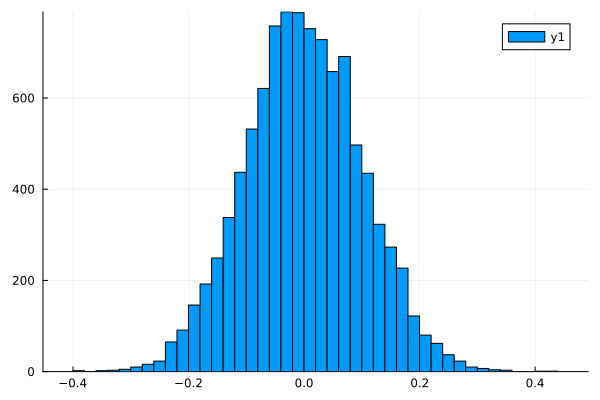

In [8]:
histogram(projected[:, 280, 2])

In [9]:
function nth_moment(data, N)
    return mean(data .^ N)
end

nth_moment (generic function with 1 method)

In [10]:
using HypothesisTests

In [11]:
JB = zeros(N)
for i in 10:N
    JB[i] = HypothesisTests.JarqueBeraTest(projected[:, i, 1]).JB
end

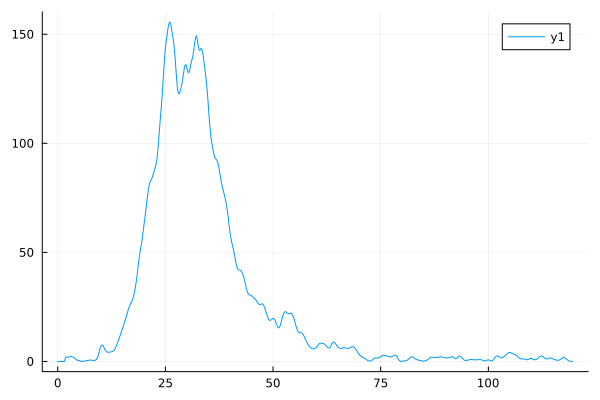

attempt to save state beyond implementation limit


In [37]:
plot(saveat[1:N-1], JB[1:N-1])

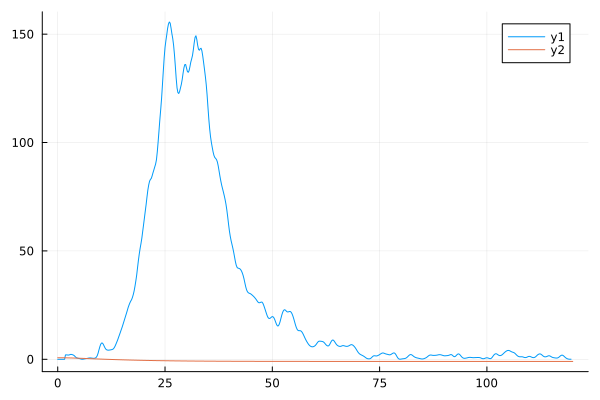

In [38]:
plot!(saveat, solavg[:, 3])

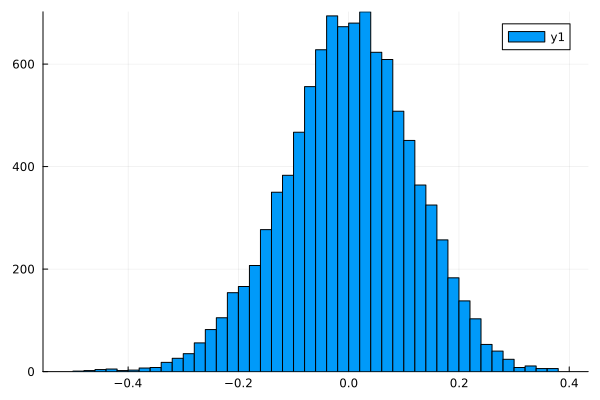

In [ ]:
histogram(projected[:, 200, 1])

In [14]:
HypothesisTests.JarqueBeraTest(projected[:, 200, 1])

Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         "0 and 3"
    point estimate:          "-0.17966985914759054 and 3.1431723658541975"

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-13

Details:
    number of observations:         10000
    JB statistic:                   62.3431
